<a href="https://colab.research.google.com/github/Hardik-Agarwal-Github/summer-of-code-2024/blob/main/machine-learning/week-1/Fraud_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import shap

## EDA

Using IEEE Fraud Detection Dataset

In [ ]:
df_train_transaction = pd.read_csv("/content/drive/MyDrive/ieee-fraud-detection/train_transaction.csv")
df_train_identity = pd.read_csv("/content/drive/MyDrive/ieee-fraud-detection/train_identity.csv")

In [ ]:
df = pd.merge(df_train_transaction, df_train_identity, on = 'TransactionID')

In [ ]:
NaN_columns = [x for x in df.columns if df[x].isna().any()]

In [ ]:
df.drop(['card1', 'card2', 'card3', 'card5', 'DeviceType', 'DeviceInfo', 'dist1', 'dist2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15'], inplace=True, axis=1)

In [ ]:
for i in range(1, 10):
  df.drop('M'+str(i), inplace=True, axis=1)

In [ ]:
for i in range(1, 340):
  df.drop('V'+str(i), inplace=True, axis=1)

In [ ]:
df.drop(['id_02', 'id_11', 'id_19', 'id_20', 'id_21', 'id_25', 'id_30', 'id_31', 'id_33'], inplace=True, axis=1)

In [ ]:
for i in df.columns:
    if df[i].isna().any() == True:
        if df[i].dtype != 'O':
            df[i] = df[i].fillna(df[i].mean())
        else:
            df[i] = df[i].fillna('U')

In [ ]:
df['id_35'] = df['id_35'].replace({'T': True, 'F': False, 'U': False})
df['id_36'] = df['id_36'].replace({'T': True, 'F': False, 'U': False})
df['id_37'] = df['id_37'].replace({'T': True, 'F': False, 'U': False})
df['id_38'] = df['id_38'].replace({'T': True, 'F': False, 'U': False})

In [ ]:
def norm_columns(df, norm_cols):
    for col in norm_cols:
        df[col] = (df[col] - df[col].min())/(df[col].max() - df[col].min())

In [ ]:
norm_cols = ['TransactionAmt', 'TransactionDT', 'addr1', 'addr2', 'id_01', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_13', 'id_14', 'id_17', 'id_18', 'id_22', 'id_24', 'id_26']

In [ ]:
norm_columns(df, norm_cols)

In [ ]:
objects = [x for x in df.columns if df[x].dtype == 'O']
objects

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_34']

In [ ]:
df = pd.get_dummies(data = df,
                         prefix = objects,
                         columns = objects)

In [ ]:
df

,TransactionID,isFraud,TransactionDT,TransactionAmt,addr1,addr2,C1,C2,C3,C4,...,id_28_New,id_28_U,id_29_Found,id_29_NotFound,id_29_U,id_34_U,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2
0,2987004,0,0.000000,0.027642,0.727273,0.836957,1.0,1.0,0.0,0.0,...,True,False,False,True,False,False,False,False,False,True
1,2987008,0,0.000002,0.008195,0.538636,0.836957,1.0,1.0,0.0,0.0,...,True,False,False,True,False,False,False,False,True,False
2,2987010,0,0.000003,0.042026,0.447375,0.828240,1.0,4.0,0.0,1.0,...,False,False,True,False,False,True,False,False,False,False
3,2987011,0,0.000003,0.009026,0.447375,0.828240,1.0,1.0,0.0,1.0,...,True,False,False,True,False,True,False,False,False,False
4,2987016,0,0.000007,0.016530,0.159091,0.836957,1.0,1.0,0.0,0.0,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,0,0.999986,0.027018,0.447375,0.828240,1.0,9.0,0.0,1.0,...,False,False,True,False,False,True,False,False,False,False
144229,3577526,1,0.999990,0.138769,0.390909,0.836957,1.0,1.0,0.0,1.0,...,True,False,False,True,False,False,False,False,False,True
144230,3577529,0,0.999992,0.040887,0.447375,0.828240,1.0,1.0,0.0,1.0,...,True,False,False,True,False,True,False,False,False,False
144231,3577531,0,0.999994,0.222114,0.538636,0.836957,2.0,3.0,0.0,4.0,...,False,False,True,False,False,False,False,False,False,True


# Oversampling

SMOTE

In [ ]:
smote = SMOTE()
df_resampled, y_resampled = smote.fit_resample(df, df['isFraud'])

In [ ]:
df_resampled

,TransactionID,isFraud,TransactionDT,TransactionAmt,addr1,addr2,C1,C2,C3,C4,...,id_28_New,id_28_U,id_29_Found,id_29_NotFound,id_29_U,id_34_U,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2
0,2987004,0,0.000000,0.027642,0.727273,0.836957,1.000000,1.000000,0.0,0.000000,...,True,False,False,True,False,False,False,False,False,True
1,2987008,0,0.000002,0.008195,0.538636,0.836957,1.000000,1.000000,0.0,0.000000,...,True,False,False,True,False,False,False,False,True,False
2,2987010,0,0.000003,0.042026,0.447375,0.828240,1.000000,4.000000,0.0,1.000000,...,False,False,True,False,False,True,False,False,False,False
3,2987011,0,0.000003,0.009026,0.447375,0.828240,1.000000,1.000000,0.0,1.000000,...,True,False,False,True,False,True,False,False,False,False
4,2987016,0,0.000007,0.016530,0.159091,0.836957,1.000000,1.000000,0.0,0.000000,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265825,3521053,1,0.889159,0.005526,0.447375,0.828240,25.446892,41.839380,0.0,10.054404,...,False,False,True,False,False,True,False,False,False,False
265826,3051951,1,0.087510,0.083205,0.854545,0.836957,3.000000,3.000000,0.0,1.000000,...,True,False,True,True,False,False,False,False,True,False
265827,3347162,1,0.561815,0.004997,0.447375,0.828240,68.621696,79.000000,0.0,17.000000,...,False,False,True,False,False,True,False,False,False,False
265828,3285486,1,0.463682,0.022958,0.447375,0.828240,35.045345,34.681782,0.0,9.000000,...,True,False,False,True,False,True,False,False,False,False


# XGBoost Model

In [ ]:
features = [x for x in df_resampled.columns if x not in 'isFraud']

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(df_resampled[features], df_resampled['isFraud'], train_size = 0.8)

In [ ]:
n = int(len(X_train)*0.7)
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [ ]:
le = LabelEncoder()
y_train_fit = le.fit_transform(y_train_fit)

In [ ]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_eval)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 212664
validation samples: 53166
target proportion: 0.4997


In [ ]:
xgb_model = XGBClassifier(n_estimators = 1000, learning_rate = 0.15,verbosity = 1, enable_categorical=True)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_fit,y_train_fit), (X_train_eval,y_train_eval)], early_stopping_rounds = 10)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.58553	validation_1-logloss:0.58551
[1]	validation_0-logloss:0.50595	validation_1-logloss:0.50575
[2]	validation_0-logloss:0.44550	validation_1-logloss:0.44546
[3]	validation_0-logloss:0.39741	validation_1-logloss:0.39748
[4]	validation_0-logloss:0.35649	validation_1-logloss:0.35661
[5]	validation_0-logloss:0.32426	validation_1-logloss:0.32428
[6]	validation_0-logloss:0.29811	validation_1-logloss:0.29827
[7]	validation_0-logloss:0.27434	validation_1-logloss:0.27444
[8]	validation_0-logloss:0.25585	validation_1-logloss:0.25583
[9]	validation_0-logloss:0.23963	validation_1-logloss:0.23967
[10]	validation_0-logloss:0.22298	validation_1-logloss:0.22333
[11]	validation_0-logloss:0.20971	validation_1-logloss:0.21027
[12]	validation_0-logloss:0.19926	validation_1-logloss:0.19994
[13]	validation_0-logloss:0.18875	validation_1-logloss:0.18958
[14]	validation_0-logloss:0.18044	validation_1-logloss:0.18145
[15]	validation_0-logloss:0.17222	validation_1-logloss:0.17329
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
train_history = xgb_model.evals_result()

In [ ]:
pred = xgb_model.predict(X_eval)

#Final Results

In [ ]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):%}\nMetrics test:\n\tAccuracy score: {accuracy_score(pred,y_eval):%}")

Metrics train:
	Accuracy score: 99.264568%
Metrics test:
	Accuracy score: 98.775533%


In [ ]:
print(f"f1 score of prediction: {f1_score(y_eval, pred):%}")

f1 score of prediction: 98.770422%


In [ ]:
print(f"precision score of prediction: {precision_score(y_eval, pred):%}")

precision score of prediction: 99.459850%


In [ ]:
print(f"recall score of prediction: {recall_score(y_eval, pred):%}")

f1 recall of prediction: 98.090486%


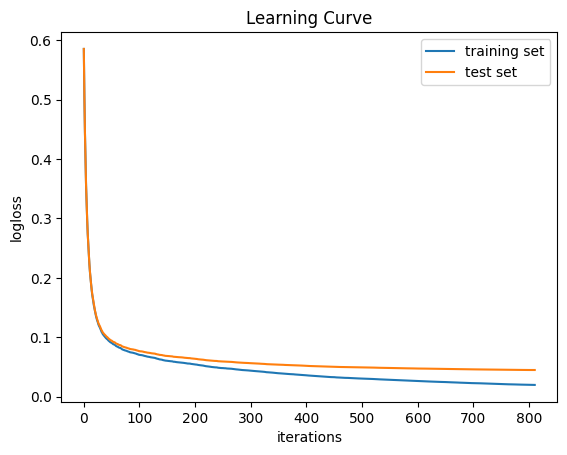

In [ ]:
plt.plot(train_history["validation_0"]["logloss"], label='training set')
plt.plot(train_history["validation_1"]["logloss"], label='test set')
plt.title('Learning Curve')
plt.xlabel('iterations')
plt.ylabel('logloss')
plt.legend()
plt.show()

# SHapley Additive exPlanations (SHAP)

In [ ]:
# Using a random sample of the dataframe for better time computation
X_sampled = X_train.sample(100, random_state=10)

In [ ]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sampled)

In [ ]:
# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

In [ ]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train)

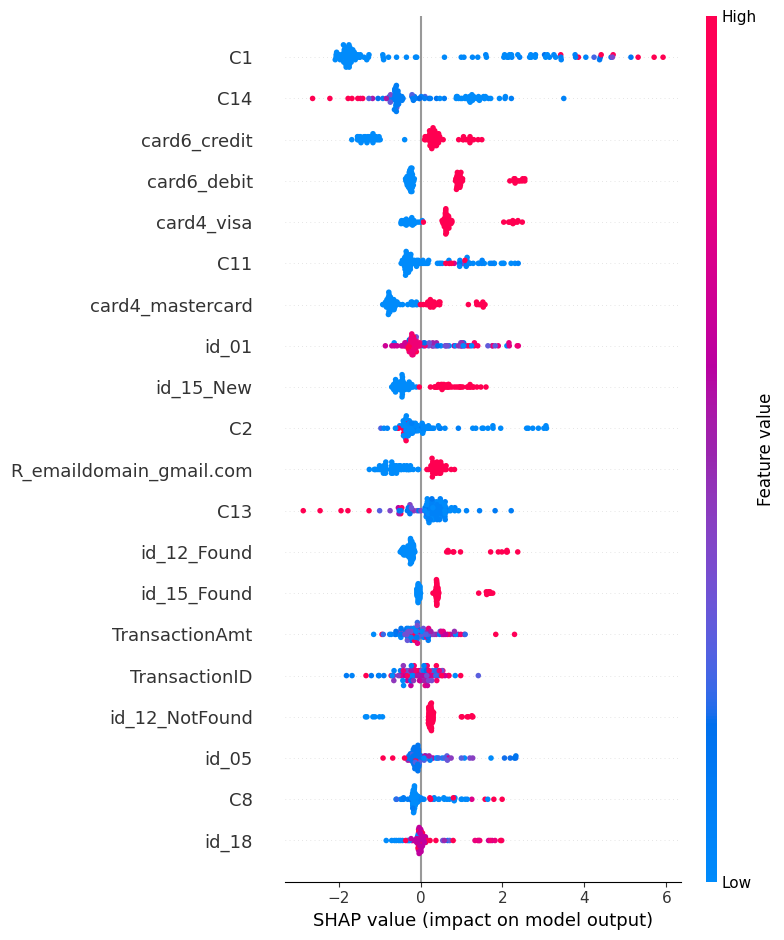

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

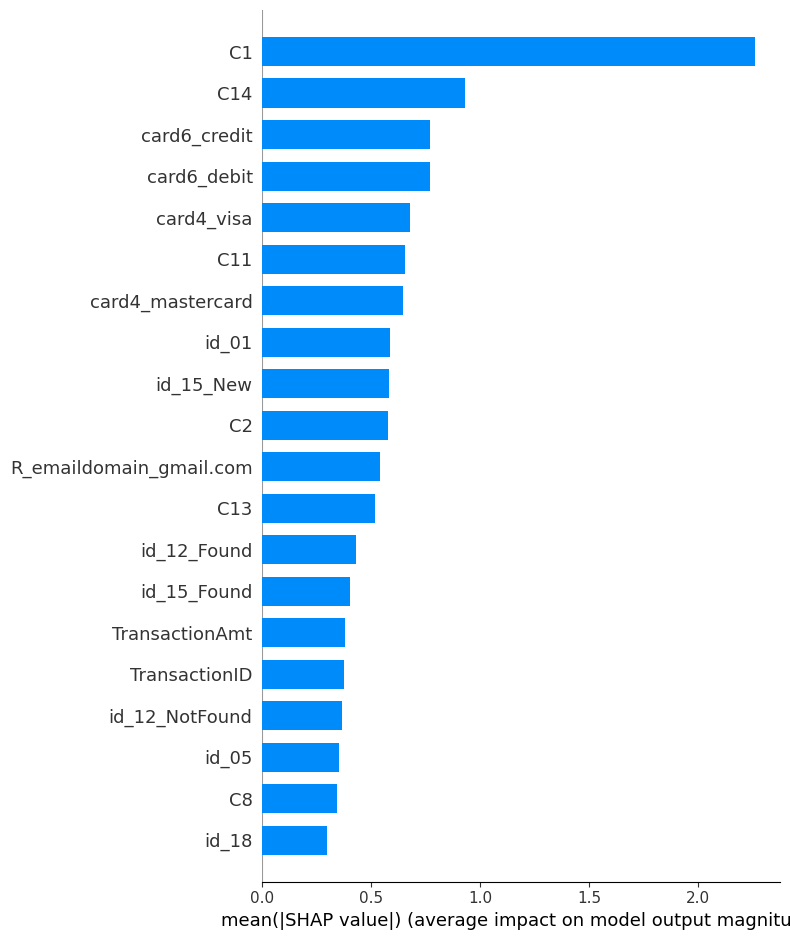

In [ ]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")